In [2]:
# HIDDEN
from datascience import *
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
import numpy as np

In the early 1960's, in Talladega County in Alabama, a black man called Robert Swain was convicted of raping a white woman and was sentenced to death. He appealed his sentence to the U.S. Supreme Court, citing among other factors the all-white jury. His case was called Swain v. Alabama. In this section, we will perform our own analysis of the data in the case and examine some questions that arise as a result.

### Jury Panels ###

A jury panel is a group of people chosen to be prospective jurors; the final trial jury is selected from among them. Jury panels can consist of a few dozen people or several thousand, depending on the trial. When Robert Swain was tried, only men aged 21 or older were allowed to serve on juries in Talladega County.  There were around 16,000 eligible jurors in Talladega County, and there were 100 people selected for Swain's jury panel.

The final jury is selected from the panel by deliberate inclusion or exclusion. The law allows potential jurors to be excused for medical reasons; lawyers on both sides may strike a certain number of potential jurors from the list for virtually any reason in what are called "peremptory challenges"; the trial judge might make a selection based on questionnaires filled out by the panel; and so on. But the initial panel is supposed to resemble a random sample of the population of eligible jurors.

### Racial bias in jury selection
Swain argued that jury selection in his original trial had been racially biased.  26% of Talladega's population of 16,000 eligible jurors were black, but there were only 8 black men among the 100 selected for the jury panel. These 8 were all struck by peremptory challenges from the prosecution, so no black man was selected for the trial jury.

In 1965, the Supreme Court of the United States denied Swain's appeal. In its ruling, the Court wrote "... the overall percentage disparity has been small and reflects no studied attempt to include or exclude a specified number of Negroes."

If the jury panel was truly a random sample from the eligible population, we can use Python to *simulate* those random samples and see what would happen.  How often do you think you would find only 8 black men in a sample of 100, from a population in which 26% are black?

If it turns out that that is an extremely rare event, then we can infer that the jury panel wasn't really a random sample from the eligible population.

### Simulating the eligible juror population

Let us first create a table to simulate the population of eligible jurors.  It will have 16,000 rows, one for each person.  Since we are interested in whether selected jurors are black or not, we will have a single column called "Race" that identifies each person as "Black" or "Non-black".

We will make use of two new `numpy` functions: `np.append` and `np.repeat`:
* `np.append` takes two arrays as its arguments, and returns a new array that contains the elements of the first array and then the elements of the second.
* `np.repeat` takes a value (like a string or number) as its first argument, and a number of repetitions as its second argument.  It returns an array containing that many copies of the value.

In [3]:
# Calculating the number of black and non-black people to simulate:
population = 16000
proportion_black = .26
num_black = int(population*proportion_black)
num_nonblack = population - num_black

black = np.repeat("Black", num_black)
non_black = np.repeat("Non-black", num_nonblack)
black_and_non_black = np.append(black, non_black)

eligible = Table().with_columns("Race", black_and_non_black)
eligible

Race
Black
Black
Black
Black
Black
Black
Black
Black
Black
Black


We can use `group` to verify that we've created the table we wanted.

In [4]:
eligible.group("Race")

Race,count
Black,4160
Non-black,11840


### Simulating random sampling
Now we will use a new Table method to produce random samples from `eligible`.  The method `sample` takes a single argument, a sample size.  It returns a new table with a random selection of rows from the original table, with length equal to the sample size.  We will use the optional argument `with_replacement=False`, which we will discuss in a later section.

In [5]:
simulated_panel = eligible.sample(100, with_replacement=False)
simulated_panel

Race
Non-black
Non-black
Non-black
Non-black
Non-black
Black
Non-black
Black
Black
Non-black


This is a simulated sample of 100 people from the eligible population.  We can again use `group` to check its racial composition:

In [7]:
simulated_panel.group("Race")

Race,count
Black,23
Non-black,77


The percentage of black people is close to 26%, the population percentage.  Maybe this was an accident, so we can try it again.

In [12]:
eligible.sample(100, with_replacement=False).group("Race")

Race,count
Black,31
Non-black,69


### Studying the outcomes of sampling

So far, it looks like 8 black people is pretty far from an ordinary outcome.  But to really be sure, we should sample more than twice.  Computers are very good at repeating a computation many times, so we will have Python do it thousands of times.  For this, it will be convenient to capture this sampling process in a function.

In [16]:
def count_black_in_sample(sample_size):
    """Simulates a jury panel of size sample_size sampled at random from the eligible population.
    
    Returns:
      int: The number of black people in the randomly-sampled jury panel."""
    return eligible.sample(sample_size, with_replacement=False)\
                   .group("Race")\
                   .where("Race", are.equal_to("Black"))\
                   .column("count").item(0)

In [20]:
count_black_in_sample(100)

24

Now we can define a table to hold our simulation results, and use `apply` to call this function repeatedly.  To better organize our code, we will encapsulate that whole process in a function.

In [22]:
def simulate_jury_pools(sample_size, num_simulations):
    """Simulates num_simulations randomly-chosen jury panels, each of size sample_size.
    
    Returns:
      Table: A table showing the simulation results.  There is one row for each
        simulation.  The 'Number black in sample' column records how many black people
        were in the simulated jury panel for each simulation."""
    sample_sizes = Table().with_columns(
        "Simulation #", np.arange(num_simulations),
        "Sample size", np.repeat(sample_size, num_simulations))
    samples = sample_sizes.with_columns(
        "Number black in sample",
        sample_sizes.apply(count_black_in_sample, "Sample size"))
    return samples

In [25]:
simulation_results = simulate_jury_pools(100, 10000)
simulation_results

Simulation #,Sample size,Number black in sample
0,100,26
1,100,26
2,100,25
3,100,29
4,100,27
5,100,30
6,100,23
7,100,17
8,100,32
9,100,20


Since there are so many simulations, we should use a histogram to display the distribution of the number of black people in the 10,000 simulations.

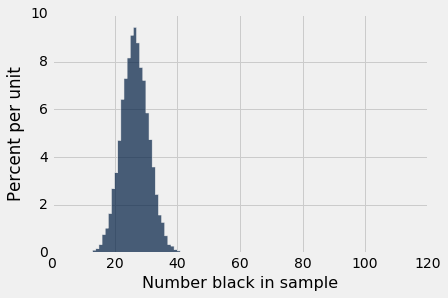

In [28]:
simulation_results.hist("Number black in sample", bins=np.arange(100+2))

The histogram tells us that, if the jury panels were really randomly sampled from the eligible population, most panels would have between 15 and 40 black people.  There would essentially *never* be as few as 8 black people, which is what happened in Swain's trial.  Let us draw a line at the number 8 to emphasize that visually.

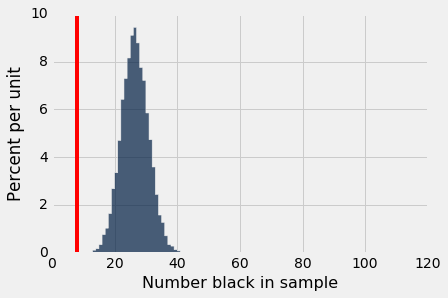

In [30]:
simulation_results.hist("Number black in sample", bins=np.arange(100+2))
plots.axvline(8, color="Red");

We have seen that histograms can be slightly misleading for displaying very small proportions.  It's a good idea to directly calculate the number of times there were fewer than 10 black jurors in our simulations:

In [32]:
simulation_results.where("Number black in sample", are.below(10)).num_rows

0

Our analysis has a clear conclusion, which is that the panel was not a random sample from the eligible popoulation. The analysis does not tell how the jury panels were actually selected. But the Supreme Court's judgment that "the overall percentage disparity has been small," which suggests that Swain might have just been a little bit unlucky in the racial composition of his panel, is certainly false.